Please add stock ticker, or enter 'exit':  QQQ
Please add stock ticker, or enter 'exit':  GOOG
Please add stock ticker, or enter 'exit':  TSLA
Please add stock ticker, or enter 'exit':  exit
Enter a year for start date:  2015
Enter a month for start date:  1
Enter a day for start date:  1


[*********************100%***********************]  3 of 3 completed


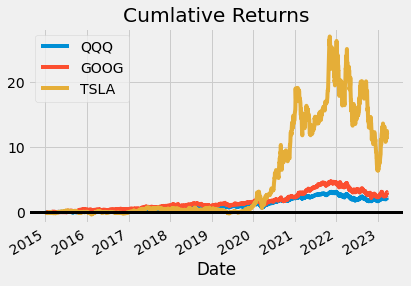

                       QQQ      GOOG      TSLA
Min Volatility    0.913205  0.082035  0.004760
Max Sharpe Ratio  0.000184  0.600731  0.399085
                  Expected Return  Volatility  Sharpe Ratio
Min Volatility           0.173475    0.228358      0.737768
Max Sharpe Ratio         0.316887    0.334223      0.933169


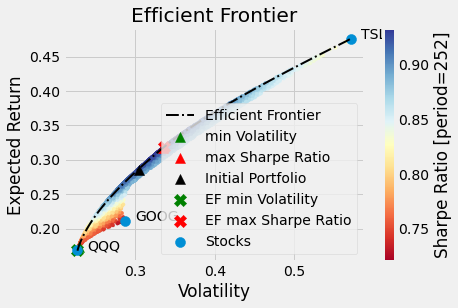

 
optimised portfolio results
        Allocation
QQQ   1.000000e+00
GOOG  0.000000e+00
TSLA  6.938894e-17
----------------------------------------------------------------------
Optimised portfolio for Minimum Volatility

Time window/frequency: 252
Risk free rate: 0.005
Expected annual Return: 0.168
Annual Volatility: 0.227
Sharpe Ratio: 0.721

Optimal weights:
            QQQ  GOOG          TSLA
Allocation  1.0   0.0  6.938894e-17
----------------------------------------------------------------------


,Allocation
QQQ,0.000000
GOOG,0.595234
TSLA,0.404766


,Allocation
QQQ,1.000000e+00
GOOG,0.000000e+00
TSLA,6.938894e-17


In [2]:
#iniitial imports
import os
import numpy as np
import requests
import pandas as pd
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
from alpaca_trade_api.rest import REST, TimeFrame
import datetime as dt
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from pandas_datareader import data as web
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from finquant.portfolio import build_portfolio
from finquant.efficient_frontier import EfficientFrontier
from finquant.moving_average import compute_ma, ema
import finta as TA
import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data import CryptoDataStream
from alpaca.data.timeframe import TimeFrame
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
import matplotlib.pyplot as plt
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
load_dotenv("key.env")
alpaca_api_key = os.getenv("Alpaca_Paper_Key_ID")
alpaca_secret_key = os.getenv("Alpaca_Paper_Secret_Key")

alpaca = REST(alpaca_api_key, alpaca_secret_key, "https://paper-api.alpaca.markets")


names = []


new_name = ''

# Start a loop that will run until the user enters 'exit'.
while new_name != 'exit':
    # Ask the user for a stock ticker
    new_name = input("Please add stock ticker, or enter 'exit': ")

    # Add the new name to our list
    if new_name != 'exit':
        names.append(new_name)

year = int(input('Enter a year for start date: '))   #year for start date
month = int(input('Enter a month for start date: ')) #month for start date
day = int(input('Enter a day for start date: '))     #day for start date

# use datetime for start_date and end_date
start_date = datetime.datetime(year, month, day)
end_date = datetime.datetime.now()


# Use build_protfolio from finquant with yahoo finance as data api otherwise it will use quandl
pf = build_portfolio(names=names,start_date=start_date, end_date=end_date, data_api="yfinance")

pf.comp_cumulative_returns().plot().axhline(y = 0, color = "black", lw = 3)
plt.title('Cumlative Returns')
plt.show()

# performs and plots results of Monte Carlo run (5000 iterations)
opt_w, opt_res = pf.mc_optimisation(num_trials=10000)

print(opt_w)
print(opt_res)

# plots the results of the Monte Carlo optimisation
pf.mc_plot_results()



# plots the Efficient Frontier
pf.ef_plot_efrontier()

# plots optimal portfolios based on Efficient Frontier
pf.ef.plot_optimal_portfolios()
# plots individual plots of the portfolio
pf.plot_stocks()
plt.show()

print(' ')
print('optimised portfolio results')
# creating an instance of EfficientFrontier
ef = EfficientFrontier(pf.comp_mean_returns(freq=1), pf.comp_cov())
# optimisation for minimum volatility
print(ef.minimum_volatility())

# printing out relevant quantities of the optimised portfolio
(expected_return, volatility, sharpe) = ef.properties(verbose=True)
target_allocation_maximum_sharpe = ef.maximum_sharpe_ratio()
target_allocation_minumum_volatility = ef.minimum_volatility()
display(target_allocation_maximum_sharpe)
display(target_allocation_minumum_volatility)

from alpaca.trading.client import TradingClient

load_dotenv("key.env")
alpaca_api_key = os.getenv("Alpaca_Paper_Key_ID")
alpaca_secret_key = os.getenv("Alpaca_Paper_Secret_Key")



trading_client = TradingClient(alpaca_api_key, alpaca_secret_key)

account = trading_client.get_account()
account

alpaca_api_key = os.getenv("Alpaca_Paper_Key_ID")
alpaca_secret_key = os.getenv("Alpaca_Paper_Secret_Key")
load_dotenv("key.env")
alpaca = REST(alpaca_api_key, alpaca_secret_key, "https://paper-api.alpaca.markets")
orders = alpaca.list_orders(status='open')
alpaca_positions = alpaca.list_positions()
portfolio_symbols = names

In [5]:
def _all_symbols_eligible_for_fractionals(portfolio_symbol):
    
    all_symbols_eligible_for_fractionals = all([[alpaca.get_asset(symbol).fractionable for symbol in portfolio_symbols]])
    return all_symbols_eligible_for_fractionals
_all_symbols_eligible_for_fractionals(portfolio_symbols)

orders = alpaca.list_orders(status='open')
alpaca_positions = alpaca.list_positions()

In [6]:
_all_symbols_eligible_for_fractionals(portfolio_symbols)

True

In [ ]:
def alpaca_symbols_to_close(alpaca_positions, portfolio_symbols):
    alpaca_symbols_to_close = [x for x in alpaca_positions if x not in portfolio_symbols]
    return alpaca_symbols_to_close

alpaca_symbols_to_close = alpaca_symbols_to_close(alpaca_positions, portfolio_symbols)
alpaca_symbols_to_close 

def alpaca_close_positions(symbols_to_close):

    for symbol in symbols_to_close:
        order_pending = True
        alpaca_order_info = alpaca.close_position(symbol)
        alpaca_client_order_id = alpaca_order_info.client_order_id
        
        while order_pending:
            alpaca_latest_order_info = alpaca.get_order_by_client_order_id(alpaca_client_order_id)
            alpaca_latest_status = alpaca_latest_order_info.status
            if alpaca_latest_status == "filled":
                order_pending = False


def _rebalance_equity(cash_weight):
    
    alpaca_account_equity = float(alpaca.get_account().equity)
    rebalance_equity = alpaca_account_equity - (alpaca_account_equity * cash_weight)
    
    return rebalance_equity

balance = alpaca.get_account().equity
print(balance)

rebalance_equity = _rebalance_equity(.05)
print(rebalance_equity)

def _portfolio_symbols_equity_allocations(target_allocations, rebalance_equity):

    portfolio_symbols_equity_allocations = {}
    for ticker, weight in target_allocations.items():
        portfolio_symbols_equity_allocations[ticker] = round((weight * rebalance_equity), 2)
    
    return portfolio_symbols_equity_allocations

portfolio_symbols_equity_allocation = _portfolio_symbols_equity_allocations(target_allocation_maximum_sharpe , rebalance_equity)

portfolio_symbols_equity_allocation




def _alpaca_latest_positions_allocations():
    
    latest_alpaca_positions_allocations = {position.symbol: float(position.market_value) for position in alpaca.list_positions()}
    return latest_alpaca_positions_allocations

def _alpaca_latest_positions():
    
    alpaca_positions = alpaca.list_positions()
    alpaca_latest_positions = [position.symbol for position in alpaca_positions]

    return alpaca_latest_positions

alpaca_latest_positions_allocations = _alpaca_latest_positions_allocations()
alpaca_latest_positions_allocations
print(portfolio_symbols_equity_allocation)
alpaca_latest_positions = _alpaca_latest_positions()
#alpaca_latest_positions
print(alpaca_latest_positions_allocations)

def _alpaca_symbols_to_sell_and_buy(portfolio_symbols_equity_allocations, latest_alpaca_positions_allocations):

    positions_to_sell, positions_to_buy = {}, {}

    # Loop Through Latest Desired Allocation
    for ticker, desired_allocation in portfolio_symbols_equity_allocations.items():

        current_allocation = latest_alpaca_positions_allocations.get(ticker, 0)
        allocation_to_adjust = desired_allocation - current_allocation

        if allocation_to_adjust > 0:
            positions_to_buy[ticker] = allocation_to_adjust
        else:
            positions_to_sell[ticker] = allocation_to_adjust * -1
    
    return positions_to_sell, positions_to_buy

_alpaca_symbols_to_sell_and_buy(portfolio_symbols_equity_allocation, alpaca_positions_allocations)



def alpaca_order(symbol, amount, side):
    
    if amount > 1:
        
        alpaca_order_info = alpaca.submit_order(symbol=symbol, notional=amount, side=side, type="market", time_in_force="day")
        alpaca_client_order_id = alpaca_order_info.client_order_id
        
        order_pending = True
        while order_pending:
            latest_alpaca_order_info = alpaca.get_order_by_client_order_id(alpaca_client_order_id)
            alpaca_latest_status = latest_alpaca_order_info.status
            sleep(2.5)
            if alpaca_latest_status == "filled":
                order_pending = False

def handle_buy_orders(positions_to_buy):
    
    for symbol, amount in positions_to_buy.items():
        alpaca_order(symbol, amount, "buy")

def handle_sell_orders(positions_to_sell):
    
    for symbol, amount in positions_to_sell.items():
        alpaca_order(symbol, amount, "sell")

def alpaca_rebalance(target_allocations, cash_weight=.05):

    portfolio_symbols = list(target_allocations.keys())

    # Check to Make Sure All Symbols are Eligible for Fractional Trading on Alpaca and Market is Open
    all_symbols_eligible_for_fractionals = _all_symbols_eligible_for_fractionals(portfolio_symbols)

    # Ensures All Symbols are Fractionable and the Market is Open
    if all_symbols_eligible_for_fractionals and alpaca.get_clock().is_open:

        # Grab Current Alpaca Holdings
        alpaca_latest_positions = _alpaca_latest_positions()

        # Construct a List of Equities to Close Based on Current Alpaca Holdings and Current Desired Holdings
        print("Closing Positions...")
        print(20*"~~")
        alpaca_symbols_to_close = _alpaca_symbols_to_close(alpaca_latest_positions, portfolio_symbols)
        
        # Close Any Alpaca Positions if Neccessary
        if alpaca_symbols_to_close:
            alpaca_close_positions(alpaca_symbols_to_close)

        # Calculate Rebalance Weight Taking Cash Weight % into Account
        print("Preparing Rebalance Equity...")
        print(20*"~~")
        rebalance_equity = _rebalance_equity(cash_weight)
        
        # Allocate the Equity to Each Holding Based on Weight and Available Portfolio Equity
        print("Preparing Positions to Sell and Buy...")
        print(20*"~~")
        portfolio_symbols_equity_allocations = _portfolio_symbols_equity_allocations(target_allocations, rebalance_equity)
        latest_alpaca_positions_allocations = _alpaca_latest_positions_allocations()
        positions_to_sell, positions_to_buy = _alpaca_symbols_to_sell_and_buy(portfolio_symbols_equity_allocations, latest_alpaca_positions_allocations)

        # Finally Adjust Allocations 
        print("Rebalancing...")
        print(20*"~~")
        handle_sell_orders(positions_to_sell)
        handle_buy_orders(positions_to_buy)

        print("Completed Rebalance!")
        print(20*"~~")



94622.23
89891.1185
{'Allocation': QQQ         0.00
GOOG    53506.23
TSLA    36384.89
Name: Allocation, dtype: float64}
{}


NameError: name 'alpaca_positions_allocations' is not defined

In [ ]:
def _alpaca_symbols_to_sell_and_buy(portfolio_symbols_equity_allocations, latest_alpaca_positions_allocations):

    positions_to_sell, positions_to_buy = {}, {}

    # Loop Through Latest Desired Allocation
    for ticker, desired_allocation in portfolio_symbols_equity_allocations.items():

        current_allocation = latest_alpaca_positions_allocations.get(ticker, 0)
        allocation_to_adjust = desired_allocation - current_allocation

        if allocation_to_adjust > 0:
            positions_to_buy[ticker] = allocation_to_adjust
        else:
            positions_to_sell[ticker] = allocation_to_adjust * -1
    
    return positions_to_sell, positions_to_buy


def alpaca_rebalance(target_allocations, cash_weight=.05):

    portfolio_symbols = list(target_allocations.keys())

    # Check to Make Sure All Symbols are Eligible for Fractional Trading on Alpaca and Market is Open
    all_symbols_eligible_for_fractionals = _all_symbols_eligible_for_fractionals(portfolio_symbols)

    # Ensures All Symbols are Fractionable and the Market is Open
    if all_symbols_eligible_for_fractionals and alpaca.get_clock().is_open:

        # Grab Current Alpaca Holdings
        alpaca_latest_positions = _alpaca_latest_positions()

        # Construct a List of Equities to Close Based on Current Alpaca Holdings and Current Desired Holdings
        print("Closing Positions...")
        print(20*"~~")
        alpaca_symbols_to_close = _alpaca_symbols_to_close(alpaca_latest_positions, portfolio_symbols)
        
        # Close Any Alpaca Positions if Neccessary
        if alpaca_symbols_to_close:
            alpaca_close_positions(alpaca_symbols_to_close)

        # Calculate Rebalance Weight Taking Cash Weight % into Account
        print("Preparing Rebalance Equity...")
        print(20*"~~")
        rebalance_equity = _rebalance_equity(cash_weight)
        
        # Calculate Latest Desired Positions Equity Allocation
        print("Calculating Latest Desired Positions Equity Allocation...")
        print(20*"~~")
        portfolio_symbols_equity_allocation = _portfolio_symbols_equity_allocations(target_allocations, rebalance_equity)

        # Grab Latest Alpaca Positions and Their Respective Allocations
        print("Grabbing Latest Alpaca Positions...")
        print(20*"~~")
        alpaca_latest_positions_allocations = _alpaca_latest_positions_allocations()
        
        # Determine Which Symbols Need to be Bought and Which Symbols Need to be Sold to Rebalance
        print("Determining Which Symbols Need to be Bought and Sold...")
        print(20*"~~")
        positions_to_sell, positions_to_buy = _alpaca_symbols_to_sell_and_buy(portfolio_symbols_equity_allocation, alpaca_latest_positions_allocations)
        
        # Handle Any Sell Orders
        print("Handling Sell Orders...")
        print(20*"~~")
        handle_sell_orders(positions_to_sell)
        
        # Handle Any Buy Orders
        print("Handling Buy Orders...")
        print(20*"~~")
        handle_buy_orders(positions_to_buy)

        print("Rebalance Complete!")
